# Анализ пользовательского поведения в мобильном приложении

Описание проекта  

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.  


После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.  


Задача
На основе данных использования мобильного приложения для продажи продуктов питания проанализировать воронку продаж, а также оценить результаты A/A/B-тестирования.  



Описание данных  

Каждая запись в логе — это действие пользователя, или событие.  

EventName — название события;  

DeviceIDHash — уникальный идентификатор пользователя;  

EventTimestamp — время события;  

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Шаг 1. Открытие файла с данными и изучение общей информации

Шаг 2. Подготовка данных

Шаг 3. Изучение и проверка данных

Шаг 4. Изучение воронки событий

Шаг 5. Изучение результатов эксперимента

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math as mth
from scipy import stats as st

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
display(data.head(10))

NameError: name 'pd' is not defined

## Шаг 2. Подготовим данные

In [3]:
#заменим название столбцов
data.columns = ['event_name', 'device_id', 'event_time', 'experiment_id']

In [4]:
#Посмотрим общую информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   event_name     244126 non-null  object
 1   device_id      244126 non-null  int64 
 2   event_time     244126 non-null  int64 
 3   experiment_id  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# Откорректируем типы данных
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data['device_id'] = data['device_id'].astype(str)
data['experiment_id'] = data['experiment_id'].astype(str)

In [6]:
# Проверим наличие дубликатов
data.duplicated().sum()

413

In [7]:
# Удалим дубликаты
data = data.drop_duplicates()
data.duplicated().sum()

0

In [8]:
#добавим столбец даты и времени, а также отдельный столбец дат
data['date'] = data['event_time'].dt.date


In [9]:
#уникальные значения
data.experiment_id.unique()

array(['246', '248', '247'], dtype=object)

In [10]:
# количество уникальных пользователей, которые оказались одновременно в нескольких группах
unique_246 = data.query('experiment_id == 246').loc[:, ['device_id', 'experiment_id']].drop_duplicates().drop(columns=['experiment_id'])
unique_247 = data.query('experiment_id == 247').loc[:, ['device_id', 'experiment_id']].drop_duplicates().drop(columns=['experiment_id'])
unique_248 = data.query('experiment_id == 248').loc[:, ['device_id', 'experiment_id']].drop_duplicates().drop(columns=['experiment_id'])
display(unique_246.isin(unique_247).sum())
display(unique_247.isin(unique_248).sum())
unique_247.isin(unique_248).sum()

device_id    0.0
dtype: float64

device_id    0.0
dtype: float64

device_id    0.0
dtype: float64

In [11]:
data.head()

,event_name,device_id,event_time,experiment_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Вывод:  

В таблице data содержится 244126 строк и 4 столбцa:  


event_name — название события
device_id — уникальный идентификатор пользователя
datetime — время события
experiment_id — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная
date - дата  

Две группы А (246 и 247) вместо одной созданы для большей точности исследования во время A/A/B-эксперимента Если две контрольные группы будут иметь существенные различия, это может помочь выявить факторы, исказившие результаты. Сравнение двух групп также позволит определить, сколько данных и времени необходимо для тестов. Пользователи во всех трех группах уникальные и не пересекаются друг с другом.

В таблице отсутствуют пропущенные значения, но есть 413 дубликатов, которые были удалены. Типы данных были откорректированы. Добавлен столбец даты.



## Шаг 3. Изучите и проверьте данные

In [12]:
print('Всего событий в логе', len(data['event_name']))

Всего событий в логе 243713


In [13]:
print('В логе всего', len(data['device_id'].value_counts()), 'пользователь')

В логе всего 7551 пользователь


In [14]:
df_events = data.pivot_table(index='device_id',values='event_name',aggfunc='count')
print('В среднем на пользователя приходится', round(df_events['event_name'].mean(), 1), 'события')

В среднем на пользователя приходится 32.3 события


In [15]:
print('Минимальная дата', data['date'].min())
print('Максимальная дата', data['date'].max())

Минимальная дата 2019-07-25
Максимальная дата 2019-08-07


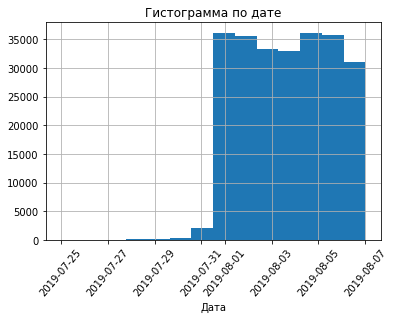

In [16]:
# Посмотрим гистограмму событий по дате
data['date'].hist(bins = 14).set_title('Гистограмма по дате')
plt.xlabel("Дата")
plt.xticks(rotation=50) 
plt.show()

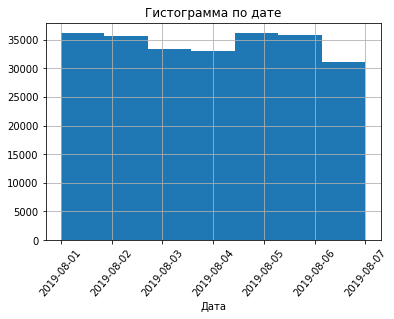

In [17]:
# Посмотрим гистограмму  событий по дате, начиная с 01.08.2019
data['date'] = pd.to_datetime(data['date'])
new_data = data.query('date > "2019-07-31"')
new_data['date'].hist(bins = 7).set_title('Гистограмма по дате')
plt.xlabel("Дата")
plt.xticks(rotation=50) 
plt.show()

In [18]:
# Посмотрим, сколько событий было потеряно
old_data = data.query('date <= "2019-07-31"')
print('Потеряно', len(old_data['event_name']), 'событий')

Потеряно 2826 событий


In [19]:
# Посмотрим, сколько пользователей было потеряно
devices_lost = 0
for row in new_data:
    if row not in old_data['device_id'].unique():
        devices_lost +=1 
print('Потеряно', devices_lost, 'пользователей')

Потеряно 5 пользователей


In [20]:
# доля отброшенных событий
round((data.shape[0] - new_data.shape[0]) / data.shape[0] * 100, 3)

1.16

In [21]:
# доля отброшенных пользователей
round((data.device_id.nunique() - new_data.device_id.nunique()) / data.device_id.nunique() * 100, 3)
round((data.device_id.nunique() - new_data.device_id.nunique()) / data.device_id.nunique() * 100, 3)

0.225

In [22]:
new_data['experiment_id'].value_counts()

248    84563
246    79302
247    77022
Name: experiment_id, dtype: int64

In [23]:
#количество device_id
new_data.groupby('experiment_id').agg({'device_id': 'nunique'})

,device_id
experiment_id,
246,2484
247,2513
248,2537


## Шаг 4. Изучим воронку событий

### Какие события есть в логах, как часто они встречаются

In [24]:
print('Всего событий в логе', len(data['event_name']))

Всего событий в логе 243713


In [25]:
# количество событий каждого вида
events = data['event_name'].value_counts()
events

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

В логе 5 видов событий, которые мы отсортировали по частоте. Чаще всего пользователи заходят на главную страницу (MainScreenAppear)

### Сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие

In [26]:
users_event = data.groupby('event_name').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False)
users_event['%'] = users_event / data.device_id.nunique() * 100
users_event

,device_id,%
event_name,,
MainScreenAppear,7439,98.516753
OffersScreenAppear,4613,61.091246
CartScreenAppear,3749,49.649053
PaymentScreenSuccessful,3547,46.973911
Tutorial,847,11.217057


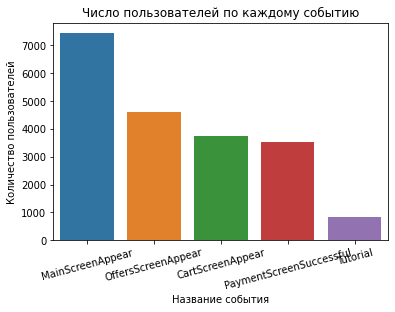

In [27]:
sns.barplot(x=users_event.index, y=users_event.device_id, data=users_event) 

plt.ylabel('Количество пользователей')
plt.xlabel('Название события')
plt.title('Число пользователей по каждому событию')
plt.xticks(rotation=15);

Судя по всему, события складываются в воронку продаж, они происходят последовательно. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты. Событие - справочник, самое не популярное, но оно не попадает в воронку.

### Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [28]:
part_of_users = data.query('event_name != "Tutorial"').groupby('event_name').agg({'device_id': 'nunique'}) \
                    .sort_values(by='device_id', ascending=False).reset_index()
part_of_users['share'] = 100 + part_of_users.device_id.pct_change() * 100
part_of_users

,event_name,device_id,share
0,MainScreenAppear,7439,NaN
1,OffersScreenAppear,4613,62.011023
2,CartScreenAppear,3749,81.270323
3,PaymentScreenSuccessful,3547,94.611897


В каталог заходят 61,91% посетителей после главной страницы, в корзину - 81,3% от количества посетителей предыдущего шага. Оплачивают 94,78% посетителей, добавивших товар в корзину. Самые большие потери происходят на этапе перехода из главной страницы на страницу каталога - 38% не доходят до второго этапа.

In [29]:
part_of_users['part_of_all'] = part_of_users.device_id / part_of_users.device_id[0] * 100
part_of_users

,event_name,device_id,share,part_of_all
0,MainScreenAppear,7439,NaN,100.000000
1,OffersScreenAppear,4613,62.011023,62.011023
2,CartScreenAppear,3749,81.270323,50.396559
3,PaymentScreenSuccessful,3547,94.611897,47.681140


*Вывод*  

Пользователи сначала заходят на главную страницу, затем в каталог с предложениями товаров, в корзину и в конце оплачивают покупку. В справочник заходят только 11,15% пользователей. Конверсия составляет меньше половины (47,7% пользователей оплачивают товары).  


Наибольшее количество посетителей отпадает после посещения главной страницы (чуть больше 38%), в корзину не доходят 19,7%, не оплачивают 5,22% после предыдущего шага.

## Шаг 5. Изучите результаты эксперимента

In [30]:
# Посмотрим сколько пользователей в каждой экспериментальной группе
groups = new_data.pivot_table(index='experiment_id',values='device_id',aggfunc='nunique')
display(groups)

,device_id
experiment_id,
246,2484
247,2513
248,2537


Проверим, находят ли статистические критерии разницу между выборками 246 и 247

In [31]:
funnel = (new_data
          .pivot_table(index='experiment_id',columns = 'event_name', values='device_id',aggfunc='nunique')
          .rename_axis(None, axis=1)
          .drop(columns='Tutorial')
         )
funnel['Total'] = new_data.groupby('experiment_id')['device_id'].nunique()
funnel

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


In [32]:
#список долей в последовательном порядке как в воронке
event_names = (funnel
               .sort_values(axis=1, by='246', ascending=False)
              .columns[1:5]
               .tolist()
              )
event_names

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful']

In [33]:
# подготовим функцию о проверке гипотезы на равенство долей
def z_test(event_names, exp_id_1, exp_id_2, alpha_value):
    
    for event in event_names:
        
        alpha = alpha_value
        
        successes = np.array([funnel[event][exp_id_1], funnel[event][exp_id_2]])
        trials = np.array([funnel['Total'][exp_id_1], funnel['Total'][exp_id_2]])

        p1 = successes[0]/trials[0]
        p2 = successes[1]/trials[1]
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print()
        
        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями групп {} и {} по событию {} есть значимая разница'
                  .format(exp_id_1, exp_id_2, event)
                 )
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп {} и {} по событию {} разными'
                .format(exp_id_1, exp_id_2, event)
                 )



Сравнение двух контрольных групп 246 и 247

Нулевая гипотеза H₀: доли пользователей, совершивших событие равны  

    
Альтернативная гипотеза H₁: доли пользователей, совершивших событие различаются   
alpha = 0.05



In [34]:
# Сделаем проверку групп А/А (246 и 247)
z_test(event_names, 0, 1, 0.05)


p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию MainScreenAppear разными

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию OffersScreenAppear разными

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию CartScreenAppear разными

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию PaymentScreenSuccessful разными


Как видно из проверги гипотез о равенстве долей, нет оснований считать контрольные выборки групп 246 и 247 разными. Равные доли говорят о том, что контрольные группы выбраны верны.
Самым популярным событием, как и ожидалось, становится показ главного экрана сайта. С этого и начинается воронка продаж.

In [35]:
#Соединим две контрольные группы в группу 249
funnel.loc['249'] = [funnel['CartScreenAppear'][0]+funnel['CartScreenAppear'][1] , funnel['MainScreenAppear'][0]+funnel['MainScreenAppear'][1], funnel['OffersScreenAppear'][0]+funnel['OffersScreenAppear'][1], funnel['PaymentScreenSuccessful'][0]+funnel['PaymentScreenSuccessful'][1], funnel['Total'][0]+funnel['Total'][1]]
display(funnel)

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
experiment_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
249,2504,4926,3062,2358,4997


In [36]:
# Сделаем проверку групп А1/B (246 и 248)
z_test(event_names, 0, 2, 0.05)



p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию MainScreenAppear разными

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию OffersScreenAppear разными

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию CartScreenAppear разными

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию PaymentScreenSuccessful разными


In [37]:
# Сделаем проверку групп А2/B (247 и 248)
z_test(event_names, 1, 2, 0.05)


p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию MainScreenAppear разными

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию OffersScreenAppear разными

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию CartScreenAppear разными

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию PaymentScreenSuccessful разными


In [38]:
# Сделаем проверку объедененной группы с экспериментальной (249 и 248)
z_test(event_names, 3, 2, 0.05)


p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию MainScreenAppear разными

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию OffersScreenAppear разными

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию CartScreenAppear разными

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию PaymentScreenSuccessful разными


Статистически значимых различий между группами 246 и экспериментальной, группами 247 и экспериментальной и объединенной контрольной группой и экспериментальной при p-value, равному 0.05, не выявлено. Т.е. изменение шрифта не повлияло на поведение пользователей. Приложение может функционировать как со старым, так и с новым шрифтом в равной степени, не влияя на отток и приток пользователей.



Изменим критический уровень статистической значимости, посчитаем при уровне значимости 0.1


In [39]:
# Сделаем проверку групп А/А (246 и 247)
z_test(event_names, 0, 1, 0.1)


p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию MainScreenAppear разными

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию OffersScreenAppear разными

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию CartScreenAppear разными

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию PaymentScreenSuccessful разными


In [40]:
# Сделаем проверку групп А1/B (246 и 248)
z_test(event_names, 0, 2, 0.1)


p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию MainScreenAppear разными

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию OffersScreenAppear разными

p-значение:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями групп 0 и 2 по событию CartScreenAppear есть значимая разница

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию PaymentScreenSuccessful разными


In [41]:
# Сделаем проверку групп А2/B (247 и 248)
z_test(event_names, 1, 2, 0.1)


p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию MainScreenAppear разными

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию OffersScreenAppear разными

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию CartScreenAppear разными

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию PaymentScreenSuccessful разными


In [42]:
# Сделаем проверку объедененной группы с экспериментальной (249 и 248)
z_test(event_names, 3, 2, 0.1)


p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию MainScreenAppear разными

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию OffersScreenAppear разными

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию CartScreenAppear разными

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию PaymentScreenSuccessful разными


Изначальный уровень значимости при проверке статистических гипотез между 3 комбинациями групп по видам событий составил 0.05. Всего провели 16 проверок гипотез, включая A/А тест. 
При увеличении уровня статистической значимости растет вероятность ошибки первого рода. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Из всех экспериментов при данном уровне значимости только в одном тесте (при сравнении 246 и экспериментальной групп) получилось отвергнуть нулевую гипотезу. Во всех случаях p-value достаточно высок, снижение p-value не повлияло бы на результат.



### Чтобы снизить групповую вероятность ошибки первого рода и скорректировать требуемые уровни значимости, используем метод Шидака

In [43]:
shidaka_alpha = 1 - (1 - 0.05) ** (1/16)
shidaka_alpha

0.0032006977101884937

In [44]:
def sh_test(event_names, exp_id_1, exp_id_2, shidaka_alpha):
    
    for event in event_names:
        
        alpha = shidaka_alpha
        
        successes = np.array([funnel[event][exp_id_1], funnel[event][exp_id_2]])
        trials = np.array([funnel['Total'][exp_id_1], funnel['Total'][exp_id_2]])

        p1 = successes[0]/trials[0]
        p2 = successes[1]/trials[1]
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print()
        
        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями групп {} и {} по событию {} есть значимая разница'
                  .format(exp_id_1, exp_id_2, event)
                 )
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп {} и {} по событию {} разными'
                .format(exp_id_1, exp_id_2, event)
                 )



In [45]:
# Сделаем проверку групп А/А (246 и 247)
sh_test(event_names, 0, 1, shidaka_alpha)


p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию MainScreenAppear разными

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию OffersScreenAppear разными

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию CartScreenAppear разными

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 1 по событию PaymentScreenSuccessful разными


In [46]:
# Сделаем проверку групп А1/B (246 и 248)
sh_test(event_names, 0, 2, shidaka_alpha)



p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию MainScreenAppear разными

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию OffersScreenAppear разными

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию CartScreenAppear разными

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 0 и 2 по событию PaymentScreenSuccessful разными


In [47]:
# Сделаем проверку групп А2/B (247 и 248)
sh_test(event_names, 1, 2, shidaka_alpha)


p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию MainScreenAppear разными

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию OffersScreenAppear разными

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию CartScreenAppear разными

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 1 и 2 по событию PaymentScreenSuccessful разными


In [48]:
# Сделаем проверку объедененной группы с экспериментальной (249 и 248)
sh_test(event_names, 3, 2, shidaka_alpha)


p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию MainScreenAppear разными

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию OffersScreenAppear разными

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию CartScreenAppear разными

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 3 и 2 по событию PaymentScreenSuccessful разными


**Общий вывод**  
    
В данном исследовании проведен анализ данных, полученных с мобильного приложения стартапа по продаже продуктов питания с 1 по 7 августа 2019 г. В датасете имеются столбцы с названием события, ID пользователя, временем события и номером экспериментальной группы. Дата записана в неправильном формате. Видны такие события: 'Появление главного экрана', 'Появление экрана оплаты' и т д. События являются частью воронки продаж на сайте. В таблице были удалены дубликаты, откорректированы типы данных, добавлен столбец с данной. Пропуски в таблице отсутствуют.  
    
В логе есть 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения. В логе всего 7551 пользователь. В среднем на пользователя приходится 32 события. Все остальные данные, а именно 1,16% событий и 0,23% пользователей были отброшены.

В ходе анализа выяснилось, что чаще всего пользователи заходят на главный экран, затем в каталог, корзину и в конце совершают покупки. Именно в такой последовательности совершаются действия. Справочником пользуется примерно десятая часть пользователей.

Чаще всего пользователи выпадают после первого шага, перехода с главной страницы в страницу с предложениями - около 38%. В корзину не добавляют товары 19,7%. Доля не оплативших после добавления в корзину достаточно низкая - 5,22%. От первого шага до оплаты доходят 47,7% пользователей.

При проведении 16 экспериментов (A/А/В тестов) статистически значимые различия между тестируемыми группами не выявлены. При повышении p-value до 0.1 различия выявлены только в одном результате, это обусловлено тем, что при уровне значимости 0.1 каждый десятый раз можно получить ложный результат.. Внедрение нового шрифта не внесло никаких изменений в использовании приложения клиентами, т.е. влияние этого фактора на конверсию практически отсутствует.
    
Благодаря методу Шидака, мы скорректировали уровень значимости = 0.0032